In [3]:
import tensorflow as tf
import numpy as np
import time
import os
#import PIL
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Concatenate
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
#import imageio
from IPython import display
print(tf.__version__)
tf.test.is_gpu_available()


2.0.0-beta1


False

W0917 10:20:47.282351 4642031040 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0917 10:20:48.365081 4642031040 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Discriminator loss : 0.7450946569442749 , Generator loss : 1.885232925415039


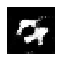

Discriminator loss : 0.6763766407966614 , Generator loss : 1.5302331447601318


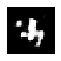

Discriminator loss : 0.6334801316261292 , Generator loss : 1.974649429321289


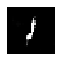

Discriminator loss : 0.9353379607200623 , Generator loss : 1.524301528930664


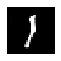

Discriminator loss : 1.0862653255462646 , Generator loss : 1.2716178894042969


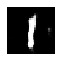

Discriminator loss : 1.0197510719299316 , Generator loss : 1.0675432682037354


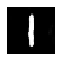

Discriminator loss : 1.022633671760559 , Generator loss : 1.25877046585083


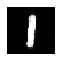

Discriminator loss : 1.1275889873504639 , Generator loss : 1.0736052989959717


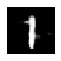

Discriminator loss : 1.2132960557937622 , Generator loss : 1.1828327178955078


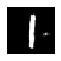

Discriminator loss : 1.2092278003692627 , Generator loss : 0.8995079398155212


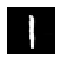

In [5]:
class Cond_GAN :
    
    def __init__(self, img_width, img_height, img_channels, num_classes):
        self.img_width = img_width
        self.img_height = img_height
        self.img_channels = img_channels
        self.num_classes = num_classes
        self.noise_dim = 100
        self.discriminator = self.discriminator_model()
        self.discriminator.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')

        self.generator = self.generator_model()
        noise = Input(shape=(self.noise_dim,))
        labels = Input(shape=(self.num_classes,))
        img_generated = self.generator([noise, labels])
        
        self.discriminator.trainable = False
        
        gan_output = self.discriminator([img_generated, labels])
        self.gan_model = Model(inputs=[noise, labels], outputs=gan_output)
        self.gan_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')
        


    def generator_model(self):
        input_noise = Input(shape=(self.noise_dim,), name='Z_noise')
        class_labels = Input(shape=(self.num_classes), name='Y')
        merged_input = Concatenate()([input_noise, class_labels])

        hidden_vals = Dense(7*7*256)(merged_input)
        hidden_vals = BatchNormalization()(hidden_vals)
        hidden_vals = LeakyReLU()(hidden_vals)
        hidden_vals = Reshape((7,7,256))(hidden_vals)

        hidden_vals = Conv2DTranspose(128, (5,5), strides=(1,1), padding='same')(hidden_vals)
        hidden_vals = BatchNormalization()(hidden_vals)
        hidden_vals = LeakyReLU()(hidden_vals)

        hidden_vals = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same')(hidden_vals)
        hidden_vals = BatchNormalization()(hidden_vals)
        hidden_vals = LeakyReLU()(hidden_vals)

        outputs = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh')(hidden_vals)

        model = Model(inputs=[input_noise, class_labels], outputs=outputs)
        return model
    
    def discriminator_model(self):
        input_image = Input(shape=(self.img_height, self.img_width, self.img_channels,), name='X')
        class_labels = Input(shape=(self.num_classes,), name='Y')

        hidden_vals = Conv2D(64, (5,5), strides=(2,2), padding='same')(input_image)
        hidden_vals = LeakyReLU()(hidden_vals)
        hidden_vals = Dropout(0.3)(hidden_vals)

        hidden_vals = Conv2D(128, (5,5), strides=(2,2), padding='same')(hidden_vals)
        hidden_vals = BatchNormalization()(hidden_vals)
        hidden_vals = LeakyReLU()(hidden_vals)
        hidden_vals = Dropout(0.3)(hidden_vals)

        hidden_vals = Flatten()(hidden_vals)

        merged_with_labels = Concatenate()([hidden_vals, class_labels])
        merged_with_labels = Dense(256, activation='relu')(merged_with_labels)
        outputs = Dense(1, activation='sigmoid')(merged_with_labels)

        model = Model(inputs=[input_image, class_labels], outputs=outputs)
        return model
    
    # Generates a tensor sampled from a random normal distribution
    def generate_uniform_noise(self, batch_size) :
        return tf.random.normal([batch_size, self.noise_dim],dtype=tf.dtypes.float32)
    
    def one_hot_encode(self, y):
        return tf.reshape(tf.one_hot(y, self.num_classes), (1,self.num_classes))
    
    def generate_img(self, input_noise, input_label, epoch) :
        label_vector = self.one_hot_encode(input_label)
        predictions = self.generator.predict([input_noise,label_vector])
        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.savefig("img_at_epoch_{}.png".format(epoch))
        plt.show()
    
    def train(self, images, labels, epochs, batch_size) :
        buffer_size = images.shape[0]
        random_fixed_noise = self.generate_uniform_noise(1)
        # Reshape to account for greyscales and normalize RGB to [-1,1] as per GoodFellow 2016
        x_train = images.reshape(images.shape[0], 28, 28, 1).astype('float32')
        x_train = (x_train - 127.5)/127.5
        y_train = to_categorical(labels, 10)
        x_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size).batch(batch_size, drop_remainder=True)
        for t in range(epochs):
            start = time.time()  
            # Shuffle the dataset
            for images_mini_batch, labels in x_train :
                noise = self.generate_uniform_noise(batch_size)
                generated_images = self.generator.predict([noise, labels])
                
                discr_real_loss = self.discriminator.train_on_batch([images_mini_batch, labels], np.ones((batch_size,1)))
                discr_fake_loss = self.discriminator.train_on_batch([generated_images, labels], np.zeros((batch_size,1)))
                
                gen_loss = self.gan_model.train_on_batch([noise, labels], np.ones((batch_size,1)))
            print("Discriminator loss : {} , Generator loss : {}".format(discr_real_loss + discr_fake_loss, gen_loss))
            self.generate_img(random_fixed_noise, 1, t)
            
    
                
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_width, img_height = x_train[0].shape
num_classes = 10
cond_gan = Cond_GAN(img_width, img_height, 1, num_classes)
cond_gan.train(x_train, y_train, 10, 32)   
    

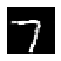

In [17]:
# Generate numbers from the trained generator now
num_to_generate = 7
random_fixed_noise = cond_gan.generate_uniform_noise(1)
cond_gan.generate_img(random_fixed_noise,num_to_generate, 0)